#Fetal Health Classification/Regression

This Kaggle [task](https://www.kaggle.com/andrewmvd/fetal-health-classification/tasks?taskId=2410) is about classify/predict the outcome of Cardiotocogram (CTG) exam, which represents the well being of the fetus. The [dataset](https://www.kaggle.com/andrewmvd/fetal-health-classification) can be found on the task page in Kaggle website.



In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM 
from tensorflow.keras.models import Sequential 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score, confusion_matrix, classification_report,plot_confusion_matrix
import seaborn as sns

#The Dataset

In [2]:
df = pd.read_csv('fetal_health.csv')
df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [3]:
# dataset columns
df.columns

Index(['baseline value', 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolongued_decelerations', 'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_long_term_variability', 'histogram_width',
       'histogram_min', 'histogram_max', 'histogram_number_of_peaks',
       'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean',
       'histogram_median', 'histogram_variance', 'histogram_tendency',
       'fetal_health'],
      dtype='object')

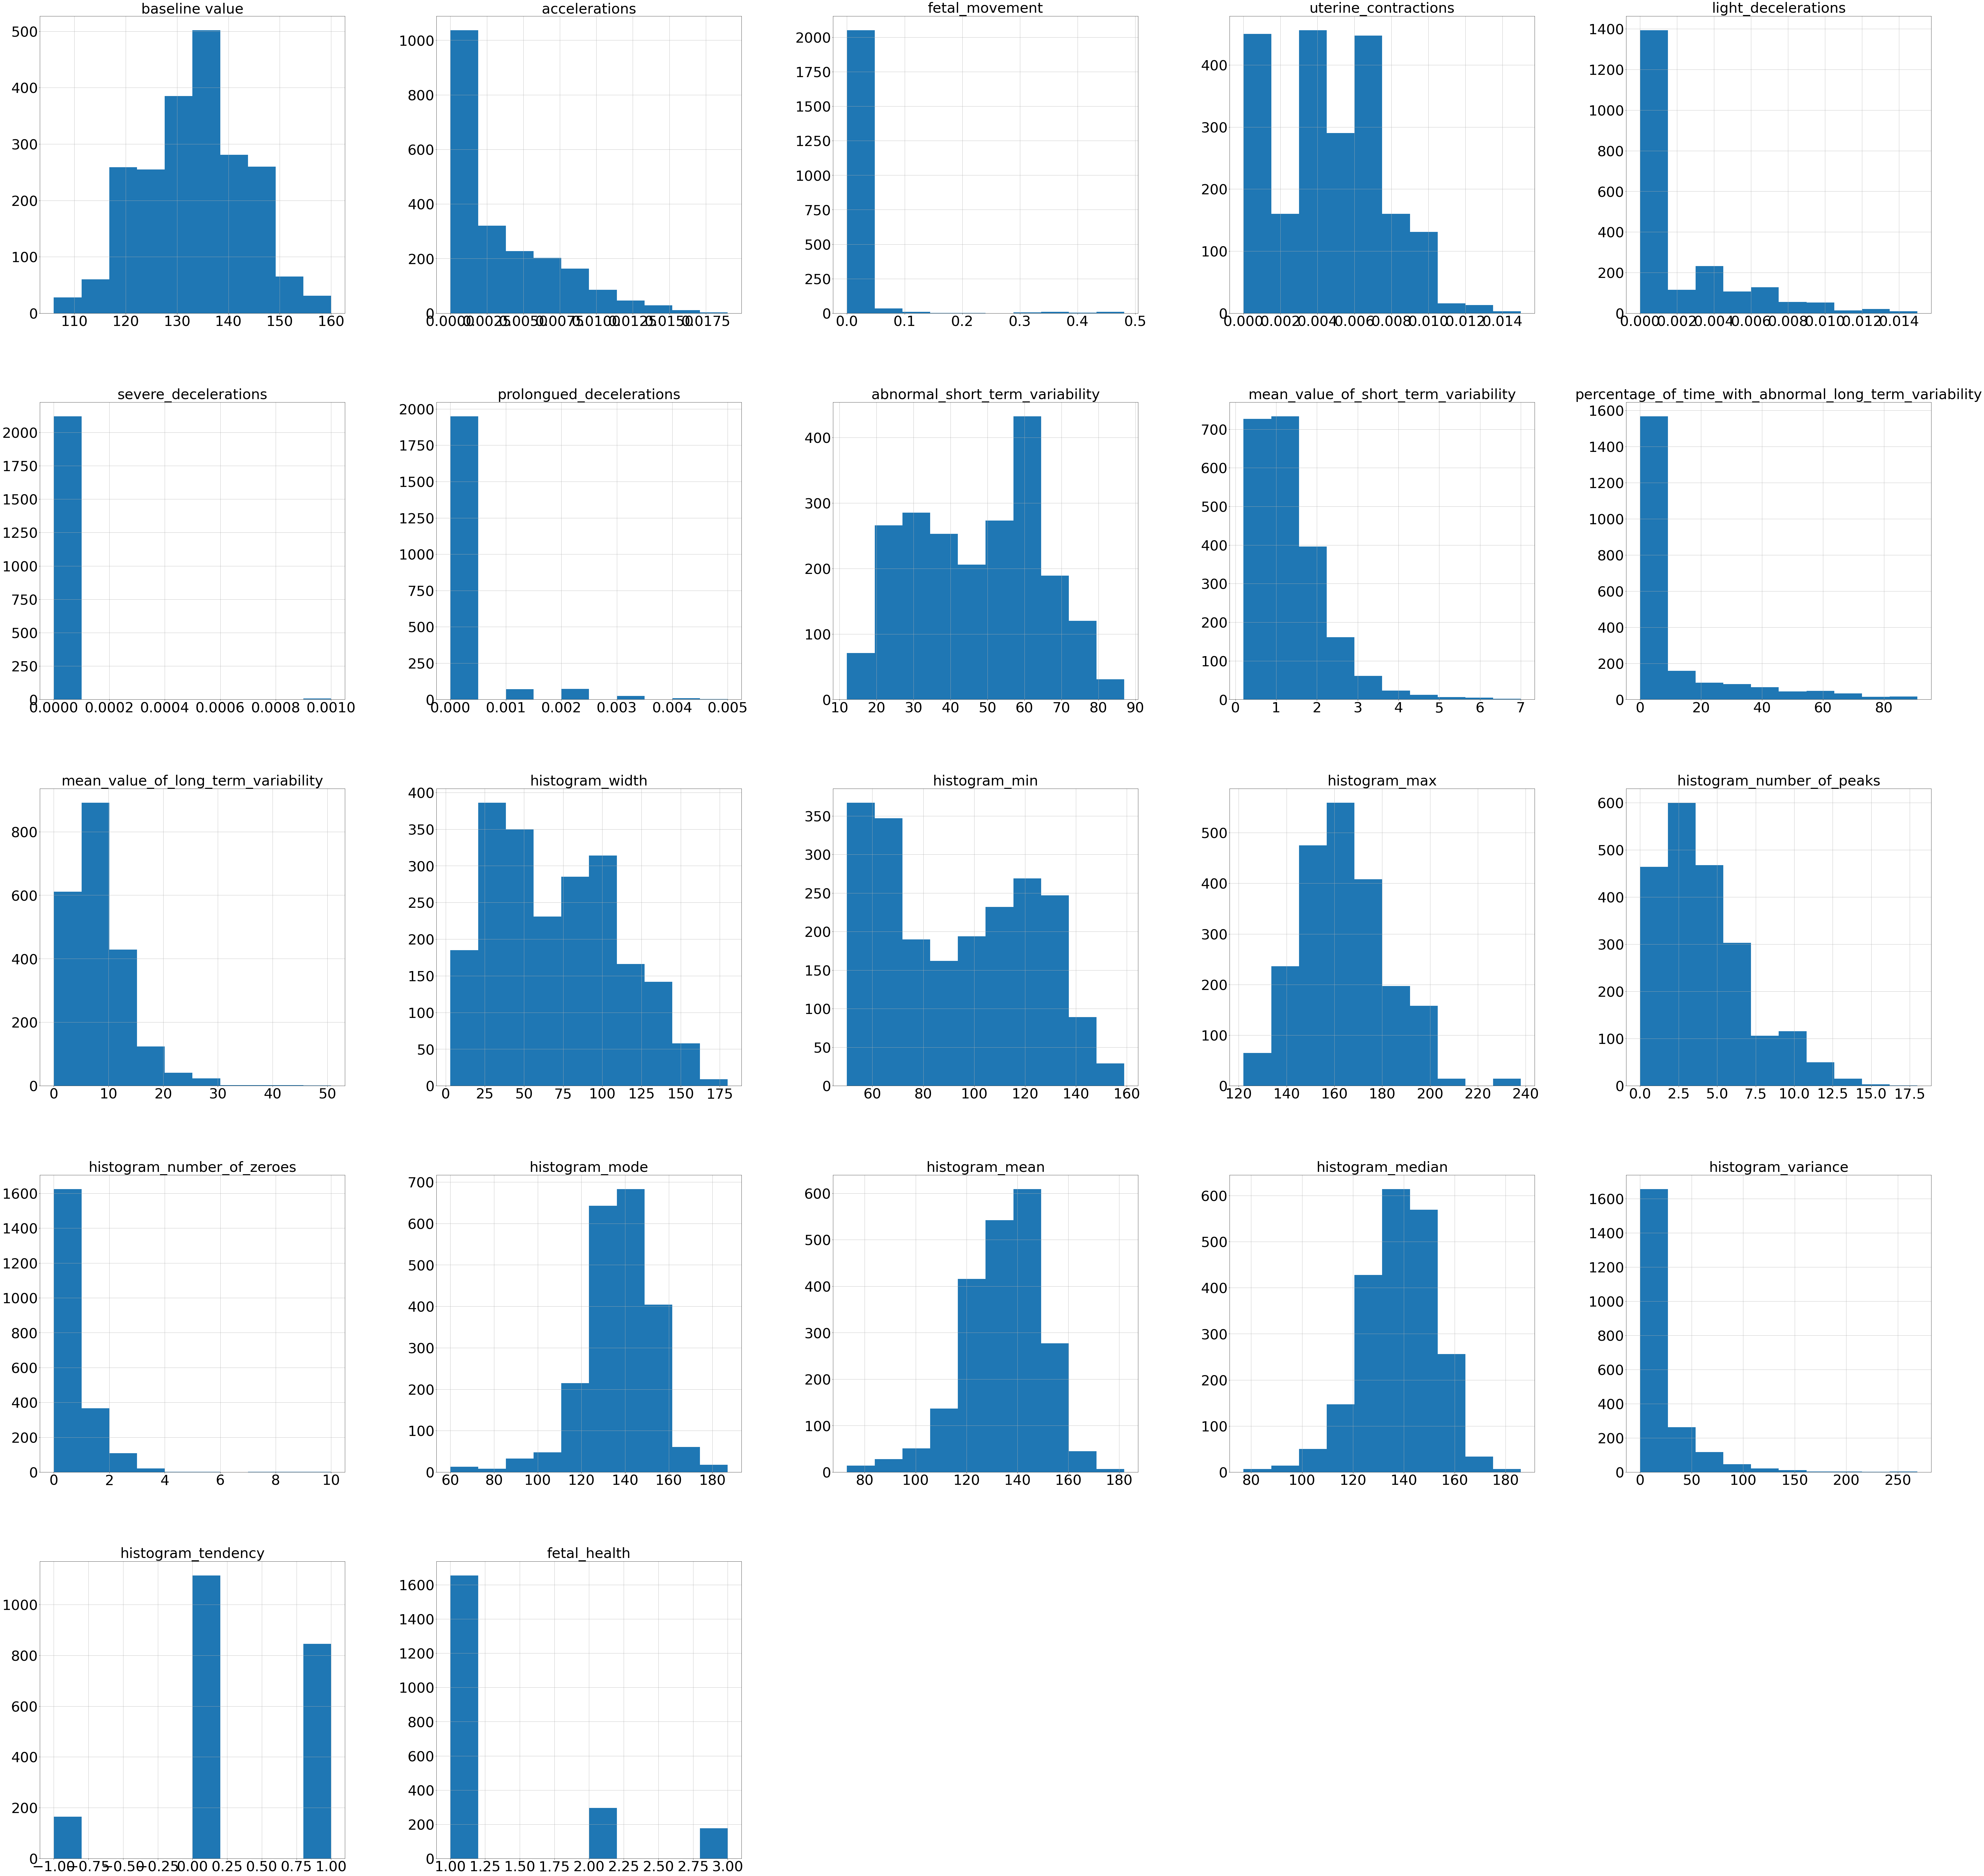

In [4]:
# just quick look at the distribution of the columns values
fig = df.hist(figsize=(120,120),xlabelsize =50,ylabelsize =50)
[x.title.set_size(50) for x in fig.ravel()]
plt.show()

In [5]:
# check the types of the columns values
df.dtypes

baseline value                                            float64
accelerations                                             float64
fetal_movement                                            float64
uterine_contractions                                      float64
light_decelerations                                       float64
severe_decelerations                                      float64
prolongued_decelerations                                  float64
abnormal_short_term_variability                           float64
mean_value_of_short_term_variability                      float64
percentage_of_time_with_abnormal_long_term_variability    float64
mean_value_of_long_term_variability                       float64
histogram_width                                           float64
histogram_min                                             float64
histogram_max                                             float64
histogram_number_of_peaks                                 float64
histogram_

In [6]:
# the target is unbalanced
df['fetal_health'].value_counts()

1.0    1655
2.0     295
3.0     176
Name: fetal_health, dtype: int64

In [7]:
# try with the orginal features, i.e. all of them
# the fetaures and the target
x = df.drop('fetal_health', axis=1)
y = df['fetal_health']
print(x.shape)
print(y.shape)

(2126, 21)
(2126,)


In [8]:
# split into train-test sets
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size =0.3, random_state=7 )

In [9]:
# normalise the features 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
s_scalar = StandardScaler()
mm_scaler = MinMaxScaler()

In [10]:
# apply StandardScaler
# x_train = s_scalar.fit(x_train).transform(x_train)
# x_test = s_scalar.fit(x_test).transform(x_test)

# apply MinMaxScaler
x_train = mm_scaler.fit(x_train).transform(x_train)
x_test = mm_scaler.fit(x_test).transform(x_test)


#The model

In [11]:
# NN model 
def define_model(x_train):
  model = Sequential()
  model.add(Dense(32,  activation='relu', input_dim=(x_train.shape[1])))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(4, activation='softmax'))
  return model

model = define_model(x_train)

In [12]:
# compile the model
loss = tf.keras.losses.sparse_categorical_crossentropy
optimizer = 'adam'
model.compile(optimizer= optimizer, loss= loss, metrics=['sparse_categorical_accuracy'])

In [13]:
# train the model
history = model.fit(x_train, y_train,epochs=500, validation_split=0.2,verbose=0)

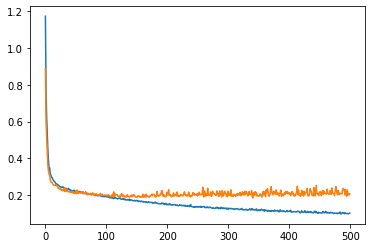

In [14]:
# plot the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

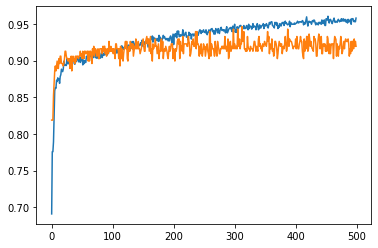

In [15]:
# plot the acc
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])

the above step was just to determine how many epochs do we need to train the model with. Now, we train without validation

In [16]:
model.compile(optimizer= optimizer, loss= loss, metrics=['sparse_categorical_accuracy'])
history = model.fit(x_train, y_train,epochs=500, verbose=0)

#The model Evalution
As the dataset is unbalanced, se the normal accuracy metric is not good. we work with cohen kappa score, which is used normally in the mdical field. Kappa is value between [0-1] and provides a measure of statistical agreement between the predicted class and the actual class that takes into consideration the probability that the model classifies correctly by chance. Kappa values \textgreater 0.75 are considered to be a strong indicator that the classifier's performance is excellent; between 0.4 to 0.75 is considered as fair to good; lower than 0.4 is understood to be weak, see [here](https://en.wikipedia.org/wiki/Cohen%27s_kappa).

In [17]:
# Evalute the model
results = model.evaluate(x_test, y_test, verbose=0)
print('the model accuracy', results[1])
print('the model loss', results[0])

the model accuracy 0.9137930870056152
the model loss 0.3918680250644684


[[473  15   0]
 [ 24  56   2]
 [  2  12  54]]


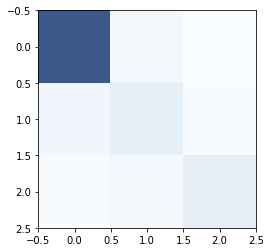

In [18]:
# extract the confusion matrix
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.imshow(cm,alpha=0.8,cmap=plt.cm.Blues)

In [19]:
# extract the other metrics
print('Kappa', cohen_kappa_score(y_pred,y_test),'\n')
print(classification_report(y_test, y_pred))

Kappa 0.7705306111772323 

              precision    recall  f1-score   support

         1.0       0.95      0.97      0.96       488
         2.0       0.67      0.68      0.68        82
         3.0       0.96      0.79      0.87        68

    accuracy                           0.91       638
   macro avg       0.86      0.82      0.84       638
weighted avg       0.91      0.91      0.91       638



In [20]:
# extract the correlation of the columns values with the target 'fetal_health'
df_corr = df.corr()

# pick the features that is most correlated with the target

# filt = (df_corr.loc['fetal_health']>0.20) | (df_corr.loc['fetal_health']<-0.30)
filt = (df_corr.loc['fetal_health']>0.20)

features = df_corr[filt].index.values.tolist()
features

['prolongued_decelerations',
 'abnormal_short_term_variability',
 'percentage_of_time_with_abnormal_long_term_variability',
 'histogram_variance',
 'fetal_health']

In [21]:
sub_df = df[features]
sub_df.head(2)

,prolongued_decelerations,abnormal_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,histogram_variance,fetal_health
0,0.0,73.0,43.0,73.0,2.0
1,0.0,17.0,0.0,12.0,1.0


In [22]:
# the fetaures and the target
x = sub_df.drop('fetal_health', axis=1)
y = sub_df['fetal_health']

In [23]:
print(x.shape)
print(y.shape)

(2126, 4)
(2126,)


In [24]:
# split into train-test sets
x_train2, x_test2, y_train2, y_test2 = train_test_split(x,y, test_size =0.3, random_state=7 )
# apply MinMaxScaler
x_train2 = mm_scaler.fit(x_train2).transform(x_train2)
x_test2 = mm_scaler.fit(x_test2).transform(x_test2)

model = define_model(x_train2)
model.compile(optimizer= optimizer, loss= loss, metrics=['sparse_categorical_accuracy'])
history = model.fit(x_train2, y_train2,epochs=500, verbose=0)

# evalue the model
y_pred = model.predict(x_test2)
y_pred = np.argmax(y_pred,axis=1)

# extract the other metrics
print('Kappa', cohen_kappa_score(y_pred,y_test2),'\n')
print(classification_report(y_test2, y_pred))

Kappa 0.7364471310741776 

              precision    recall  f1-score   support

         1.0       0.92      0.97      0.94       488
         2.0       0.75      0.56      0.64        82
         3.0       0.97      0.84      0.90        68

    accuracy                           0.91       638
   macro avg       0.88      0.79      0.83       638
weighted avg       0.90      0.91      0.90       638



#Notices:
we can mitigate the unbalance using many techniques inlcudeing oversampling or undersampling, see [here](https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/).

In [25]:
# from imblearn.over_sampling import RandomOverSampler
# x_train_balance,y_train_balance = RandomOverSampler(random_state = 7).fit_resample(x_train,y_train)

#Different classiffiers

**SVM**


In [26]:
from sklearn.svm import SVC

In [27]:
svmModel = SVC()

In [28]:
svmModel.fit(x_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [29]:
y_pred = svmModel.predict(x_test)
print('Kappa', cohen_kappa_score(y_pred,y_test),'\n')
print(classification_report(y_test, y_pred))

Kappa 0.7114850036576444 

              precision    recall  f1-score   support

         1.0       0.93      0.96      0.94       488
         2.0       0.62      0.65      0.63        82
         3.0       1.00      0.71      0.83        68

    accuracy                           0.89       638
   macro avg       0.85      0.77      0.80       638
weighted avg       0.90      0.89      0.89       638



**Random Froest**

In [30]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
RF = RandomForestClassifier()
RF.fit(x_train, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [32]:
y_pred = RF.predict(x_test)
print('Kappa', cohen_kappa_score(y_pred,y_test),'\n')
print(classification_report(y_test, y_pred))

Kappa 0.7888558692421991 

              precision    recall  f1-score   support

         1.0       0.94      0.98      0.96       488
         2.0       0.77      0.66      0.71        82
         3.0       1.00      0.84      0.91        68

    accuracy                           0.92       638
   macro avg       0.90      0.83      0.86       638
weighted avg       0.92      0.92      0.92       638



**LR**

In [33]:
from sklearn.linear_model import LogisticRegression

In [34]:
LR = LogisticRegression(random_state=0).fit(x_train, y_train)

In [35]:
y_pred = LR.predict(x_test)
print('Kappa', cohen_kappa_score(y_pred,y_test),'\n')
print(classification_report(y_test, y_pred))

Kappa 0.6699474717461664 

              precision    recall  f1-score   support

         1.0       0.92      0.95      0.94       488
         2.0       0.58      0.61      0.60        82
         3.0       0.94      0.66      0.78        68

    accuracy                           0.88       638
   macro avg       0.81      0.74      0.77       638
weighted avg       0.88      0.88      0.88       638



**XGBClassifier**

In [36]:
from xgboost import XGBClassifier

In [37]:
XGB = XGBClassifier().fit(x_train, y_train)

In [38]:
y_pred = XGB.predict(x_test)
print('Kappa', cohen_kappa_score(y_pred,y_test),'\n')
print(classification_report(y_test, y_pred))

Kappa 0.825805445042515 

              precision    recall  f1-score   support

         1.0       0.95      0.97      0.96       488
         2.0       0.78      0.74      0.76        82
         3.0       0.98      0.91      0.95        68

    accuracy                           0.93       638
   macro avg       0.91      0.87      0.89       638
weighted avg       0.93      0.93      0.93       638



In [39]:
XGB.feature_importances_.shape

(21,)

In [40]:
features = [c for c in df.columns if c != "fetal_health"]
features

['baseline value',
 'accelerations',
 'fetal_movement',
 'uterine_contractions',
 'light_decelerations',
 'severe_decelerations',
 'prolongued_decelerations',
 'abnormal_short_term_variability',
 'mean_value_of_short_term_variability',
 'percentage_of_time_with_abnormal_long_term_variability',
 'mean_value_of_long_term_variability',
 'histogram_width',
 'histogram_min',
 'histogram_max',
 'histogram_number_of_peaks',
 'histogram_number_of_zeroes',
 'histogram_mode',
 'histogram_mean',
 'histogram_median',
 'histogram_variance',
 'histogram_tendency']

In [41]:
feature_df = pd.DataFrame()
feature_df['label'] = features
feature_df['importance'] = XGB.feature_importances_
feature_df

,label,importance
0,baseline value,0.037399
1,accelerations,0.072965
2,fetal_movement,0.014383
3,uterine_contractions,0.028215
4,light_decelerations,0.014641
5,severe_decelerations,0.000000
6,prolongued_decelerations,0.072759
7,abnormal_short_term_variability,0.060122
8,mean_value_of_short_term_variability,0.183624
9,percentage_of_time_with_abnormal_long_term_var...,0.104784


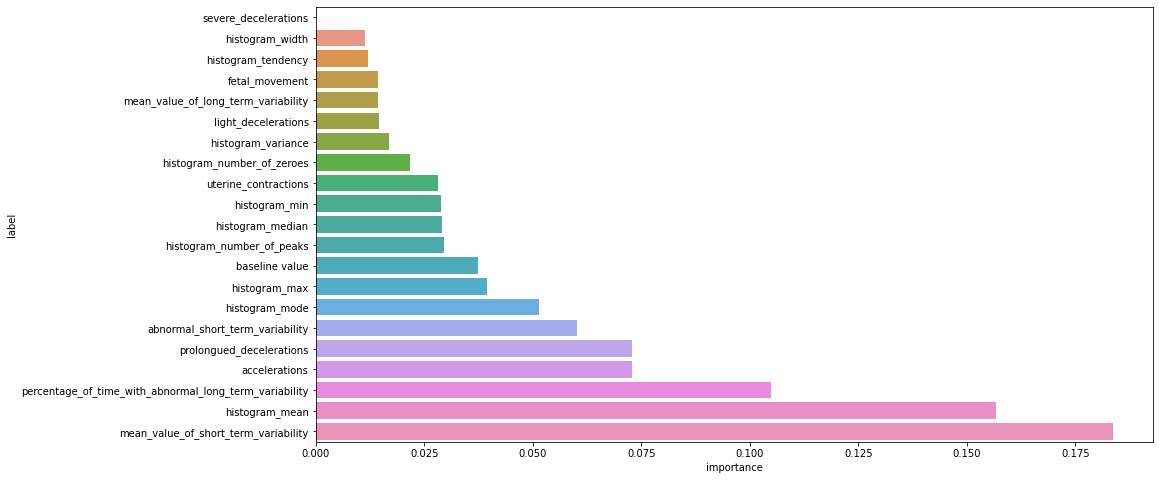

In [42]:
plt.figure(figsize=(15,8))
sns.barplot(y="label",x="importance",order=feature_df.sort_values("importance").label,data=feature_df)